<img src='files/exeter_logo_grey.png' width=500 height=500 />

<p class='alert alert-success' style='font-size:30px;text-align:center;'>
    Covid-19 UK Mobility Project - Data Exploration
</p>

In [1]:
%matplotlib inline
import gc as garbage
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from aux_functions import *
import statsmodels.api as sma
%load_ext autoreload
%autoreload 2

In [2]:
file_months = {'20.01-02_full_result':[1, 2], '20.03-04_full_result':[3, 4], 
               '20.05-06_full_result':[5, 6], '20.07-08_full_result':[7, 8], 
               '20.09_full_result':[9], '20.10_full_result':[10], '20.11_full_result':[11], 
               '20.12_full_result':[12]}
file_months_2021 = {'21.01_full_result':[1], '21.02_full_result':[2]}

sync_df = load_sync_data(file_months, year=2020)
sync_df['year'] = sync_df.dt.apply(lambda x: x.year)
sync_df_ = sync_df.groupby(['geo_code', 'week', 'month', 'year'])['count'].sum()
sync_df_ = sync_df_.reset_index()
history_out_home_df = get_metric(sync_df_, count_by='count')

sync_df_2021 = load_sync_data(file_months_2021, year=2021)
sync_df_2021['year'] = sync_df_2021.dt.apply(lambda x: x.year)
sync_df_2021_ = sync_df_.groupby(['geo_code', 'week', 'month', 'year'])['count'].sum()
sync_df_2021_ = sync_df_2021_.reset_index()
history_out_home_df_2021 = get_metric(sync_df_2021_, count_by='count')

sync_df.head()

,hourr,count,date,geo_code,dt,month,week,weekday,region,country,year
0,21,4207,60,E06000056,2020-02-29,2,9,5,East,England,2020
1,6,6394,55,E06000056,2020-02-24,2,9,0,East,England,2020
2,0,1673,60,E06000056,2020-02-29,2,9,5,East,England,2020
3,21,4583,57,E06000056,2020-02-26,2,9,2,East,England,2020
4,11,10636,53,E06000056,2020-02-22,2,8,5,East,England,2020


In [3]:
file_months_2019 = {'19.01_full_result':[1], '19.02-03_full_result':[2, 3],
                    '19.04-05_full_result':[4, 5], '19.06-07_full_result':[6, 7], 
                    '19.08_full_result':[8], '19.09_full_result':[9], 
                    '19.10_full_result':[10], '19.11_full_result':[11], '19.12_full_result':[12]}

sync_df_2019 = load_sync_data(file_months_2019, year=2019)
sync_df_2019['year'] = sync_df_2019.dt.apply(lambda x: x.year)
sync_df_2019.head()

,hourr,count,date,geo_code,dt,month,week,weekday,region,country,year
0,16,8095,25,E07000082,2019-01-25,1,4,4,South West,England,2019
1,7,3909,31,E07000082,2019-01-31,1,5,3,South West,England,2019
2,8,7179,30,E07000082,2019-01-30,1,5,2,South West,England,2019
3,15,2989,24,E07000082,2019-01-24,1,4,3,South West,England,2019
4,7,2922,24,E07000082,2019-01-24,1,4,3,South West,England,2019


In [4]:
sync_df_merged = pd.concat([sync_df, sync_df_2021], axis=0)
sync_df_merged.head()

,hourr,count,date,geo_code,dt,month,week,weekday,region,country,year
0,21,4207,60,E06000056,2020-02-29,2,9,5,East,England,2020
1,6,6394,55,E06000056,2020-02-24,2,9,0,East,England,2020
2,0,1673,60,E06000056,2020-02-29,2,9,5,East,England,2020
3,21,4583,57,E06000056,2020-02-26,2,9,2,East,England,2020
4,11,10636,53,E06000056,2020-02-22,2,8,5,East,England,2020


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


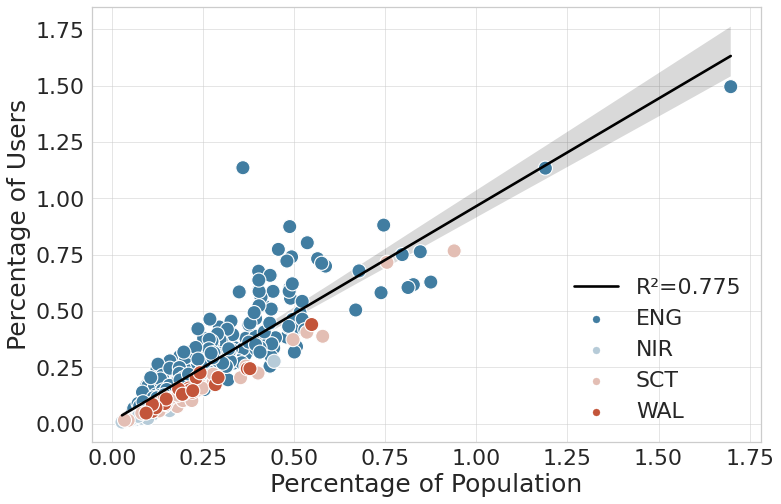

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     1386.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          2.51e-132
Time:                        12:24:18   Log-Likelihood:                 402.39
No. Observations:                 404   AIC:                            -800.8
Df Residuals:                     402   BIC:                            -792.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113      0.008      1.455      0.1

In [5]:
pop_data = pd.read_csv('files/uk_pop_census.csv')
pop_sync = pop_data.merge(sync_df, on='geo_code')
pop_sync = pop_sync.groupby('geo_code').mean().reset_index()
pop_sync['pop_perc'] = 100 * pop_sync.population / pop_sync.population.sum()
pop_sync['ping_perc'] = 100* pop_sync['count'] / pop_sync['count'].sum()

pop_sync['country'] = pop_sync[['geo_code']].apply(get_la_color, axis=1)
pop_sync= pop_sync.sort_values(['country'])

f, ax = plt.subplots(figsize=(12, 8))
var1, var2 = 'pop_perc', 'ping_perc'
regr = LinearRegression()
regr = regr.fit(pop_sync[var1].values.reshape(-1, 1), pop_sync[var2].values.reshape(-1, 1))
linear_r2 = r2_score(pop_sync[var2].values.reshape(-1, 1),
                     regr.predict(pop_sync[var1].values.reshape(-1, 1)))

sns.regplot(x=pop_sync[var1].values, y=pop_sync[var2].values, scatter=False, color='black',  ax=ax, 
            label='R²={:.3f}'.format(linear_r2))

n_cmapr=['#00a3f1', '#f5d200', '#404040', '#1B263B']
rdgn = sns.diverging_palette(235, 20, n=4)
sns.scatterplot(x=var1, y=var2, hue=pop_sync.country.values, s=200, 
                data=pop_sync, palette=rdgn, legend='full')

ax.grid(linewidth=.5)
ax.set_xlabel('Percentage of Population', fontsize=25)
ax.set_ylabel('Percentage of Users', fontsize=25)
ax.legend(loc='lower right', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("figures/data_validation.pdf", dpi=600)
plt.show()

X = pop_sync[var1].values.reshape(-1, 1)
y = pop_sync[var2].values.reshape(-1, 1)
X2  = sma.add_constant(X)

est  = sma.OLS(y, X2)
_2  = est.fit()

print(_2.summary())

In [6]:
pop_sync_soc = load_income_density_socio_data(pop_sync)
urban_rural_df = pd.read_csv('files/RUC11_LAD11_ENG.csv')
pop_sync_soc = pop_sync_soc.merge(urban_rural_df[['geo_code', 'RUC11CD']], on='geo_code')
pop_sync_soc.RUC11CD = pop_sync_soc.RUC11CD.astype(int)
pop_sync_soc['NRUC11'] = pop_sync_soc.RUC11CD.apply(lambda x: get_new_ru_text(x))

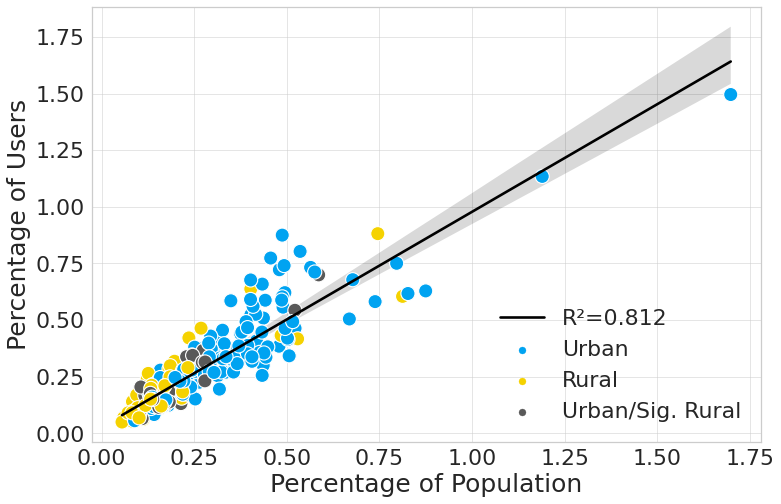

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1352.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          8.21e-116
Time:                        12:24:21   Log-Likelihood:                 351.85
No. Observations:                 316   AIC:                            -699.7
Df Residuals:                     314   BIC:                            -692.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0276      0.008      3.448      0.0

In [7]:
from matplotlib.colors import ListedColormap
f, ax = plt.subplots(figsize=(12, 8))
var1, var2 = 'pop_perc', 'ping_perc'
regr = LinearRegression()
regr = regr.fit(pop_sync_soc[var1].values.reshape(-1, 1), pop_sync_soc[var2].values.reshape(-1, 1))
linear_r2 = r2_score(pop_sync_soc[var2].values.reshape(-1, 1),
                     regr.predict(pop_sync_soc[var1].values.reshape(-1, 1)))

sns.regplot(x=pop_sync_soc[var1].values, y=pop_sync_soc[var2].values, scatter=False, color='black',  ax=ax, 
            label='R²={:.3f}'.format(linear_r2))

colors_ru = ['#00a3f1', '#f5d200', '#595959',]
sns.scatterplot(x=var1, y=var2, hue=pop_sync_soc.NRUC11.values, s=200, legend='full', 
                data=pop_sync_soc, palette=colors_ru)

ax.grid(linewidth=.5)
ax.set_xlabel('Percentage of Population', fontsize=25)
ax.set_ylabel('Percentage of Users', fontsize=25)
ax.legend(loc='lower right', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("figures/data_validation_ru.pdf", dpi=600)
plt.show()

X = pop_sync_soc[var1].values.reshape(-1, 1)
y = pop_sync_soc[var2].values.reshape(-1, 1)
X2  = sma.add_constant(X)

est  = sma.OLS(y, X2)
_2  = est.fit()

print(_2.summary())

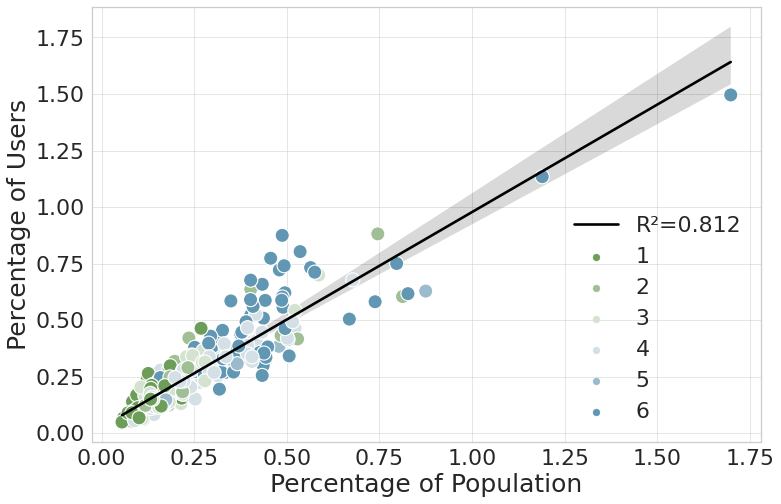

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1352.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          8.21e-116
Time:                        12:24:22   Log-Likelihood:                 351.85
No. Observations:                 316   AIC:                            -699.7
Df Residuals:                     314   BIC:                            -692.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0276      0.008      3.448      0.0

In [8]:
f, ax = plt.subplots(figsize=(12, 8))
var1, var2 = 'pop_perc', 'ping_perc'
regr = LinearRegression()
regr = regr.fit(pop_sync_soc[var1].values.reshape(-1, 1), pop_sync_soc[var2].values.reshape(-1, 1))
linear_r2 = r2_score(pop_sync_soc[var2].values.reshape(-1, 1),
                     regr.predict(pop_sync_soc[var1].values.reshape(-1, 1)))

sns.regplot(x=pop_sync_soc[var1].values, y=pop_sync_soc[var2].values, scatter=False, color='black',  ax=ax, 
            label='R²={:.3f}'.format(linear_r2))

c=sns.diverging_palette(230, 0, 90, 60, as_cmap=True)
rdgn = sns.diverging_palette(120, 230, 60, 60, as_cmap=True)
sns.scatterplot(x=var1, y=var2, hue=pop_sync_soc.RUC11CD.values, s=200, data=pop_sync_soc, 
                palette=rdgn, legend='full')

ax.grid(linewidth=.5)
ax.set_xlabel('Percentage of Population', fontsize=25)
ax.set_ylabel('Percentage of Users', fontsize=25)
ax.legend(loc='lower right', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("figures/data_validation_ul.pdf", dpi=600)
plt.show()


X = pop_sync_soc[var1].values.reshape(-1, 1)
y = pop_sync_soc[var2].values.reshape(-1, 1)
X2  = sma.add_constant(X)

est  = sma.OLS(y, X2)
_2  = est.fit()

print(_2.summary())

In [9]:
radius_df = load_radius_data('radius/2020/*')
radius_df['year'] = [2020] * len(radius_df)
radius_df['month'] = radius_df['week'].apply(lambda x: datetime.datetime.strptime("{}-{}-1".format(2020, x), "%Y-%W-%w").month)

radius_2019_df = load_radius_data('radius/2019/*')
radius_2019_df['year'] = [2019] * len(radius_2019_df)
radius_2019_df['month'] = radius_2019_df['week'].apply(lambda x: datetime.datetime.strptime("{}-{}-1".format(2019, x), "%Y-%W-%w").month)

radius_2021_df = load_radius_data('radius/2021/*')
radius_2021_df['year'] = [2021] * len(radius_2021_df)
radius_2021_df['month'] = radius_2021_df['week'].apply(lambda x: datetime.datetime.strptime("{}-{}-1".format(2021, x), "%Y-%W-%w").month)

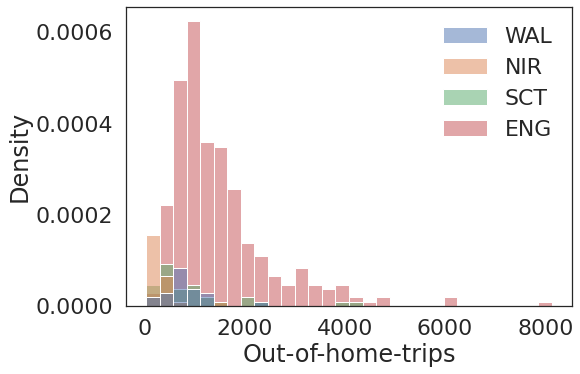

In [10]:
sns.set(font_scale=2)
sns.set_style('white')
rdgn = sns.diverging_palette(235, 20, n=4)
ax = sns.histplot(data=pop_sync, x="count", hue="country", stat='density',
                 hue_order=["WAL", "NIR", "SCT", "ENG"], )
sns.move_legend(ax, "upper right", ncol=1, title=None, frameon=False,)
# plt.xlim([0.5, 7.5])
# plt.ylim([0, 0.4])

plt.xlabel("Out-of-home-trips")
#     ax.get_legend().remove()
plt.savefig("figures/density_out_home_uk.pdf", dpi=600)
plt.show()

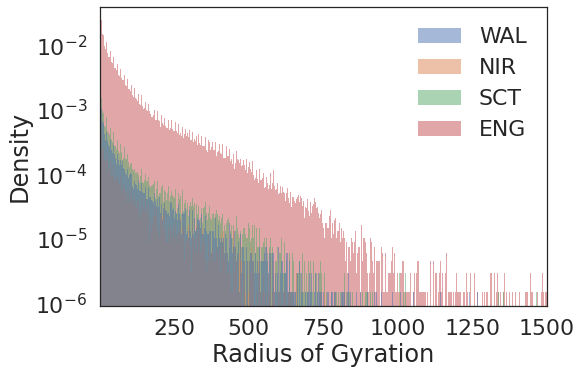

In [11]:
sns.set(font_scale=2)
sns.set_style('white')
radius_df['country1'] = radius_df[['geo_code']].apply(get_la_color, axis=1)
ax = sns.histplot(data=radius_df[radius_df.week==13], x="pings",
                  hue="country1", stat='density', hue_order=["WAL", "NIR", "SCT", "ENG"],)
sns.move_legend(ax, "upper right", ncol=1, title=None, frameon=False)
plt.xlim([0.5, 1500])
ax.set_yscale('log')
plt.xlabel("Radius of Gyration")

plt.savefig("figures/radius_out_home_uk.pdf", dpi=600)
plt.show()

In [12]:
urban_rural_df = pd.read_csv('files/RUC11_LAD11_ENG.csv')
radius_df_soc = radius_df.merge(urban_rural_df[['geo_code', 'RUC11CD']], on='geo_code')
radius_df_soc.RUC11CD = radius_df_soc.RUC11CD.astype(int)
radius_df_soc['NRUC11'] = radius_df_soc.RUC11CD.apply(lambda x: get_new_ru_text(x))


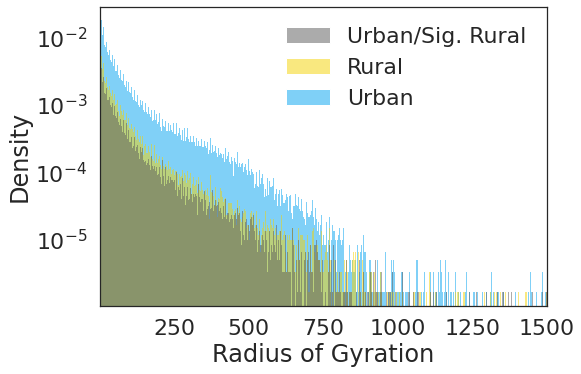

In [13]:
sns.set(font_scale=2)
sns.set_style('white')
colors_ru = [ '#595959','#f5d200', '#00a3f1',]
ax = sns.histplot(data=radius_df_soc[radius_df_soc.week==13], x="pings", 
                  hue="NRUC11", stat='density', palette=colors_ru, 
                 hue_order = ['Urban/Sig. Rural', 'Rural', 'Urban'])
sns.move_legend(ax, "upper right", ncol=1, title=None, frameon=False,)
plt.xlim([0.5, 1500])
ax.set_yscale('log')
plt.xlabel("Radius of Gyration")
plt.savefig("figures/radius_out_home_ru.pdf", dpi=600)
plt.show()

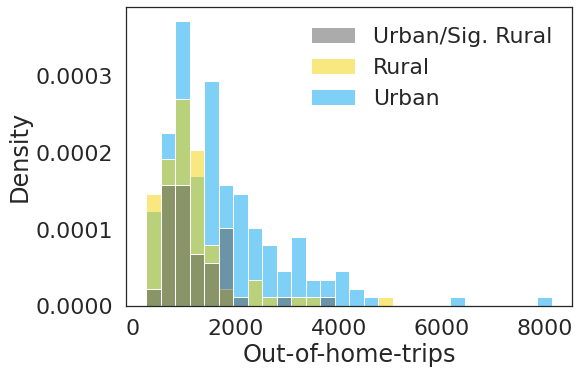

In [14]:
sns.set(font_scale=2)
sns.set_style('white')
ax = sns.histplot(data=pop_sync_soc, x="count", hue="NRUC11",
                  stat='density', palette=colors_ru, 
                 hue_order = ['Urban/Sig. Rural', 'Rural', 'Urban'])
sns.move_legend(ax, "upper right", ncol=1, title=None, frameon=False,)
plt.xlabel("Out-of-home-trips")
plt.savefig("figures/density_out_home_ru.pdf", dpi=600)
plt.show()

In [15]:
regs_ = pd.read_csv('files/region_geocode.csv')[['region', 'geo_code']]
rus_ = pd.read_csv('files/ru_geocode.csv')[['RUC11CD', 'Rural population1', 'geo_code']]
rus_['pop_log'] = rus_['Rural population1'].apply(np.log)
regs_ = rus_.set_index("geo_code").join(regs_.set_index("geo_code"), on="geo_code").reset_index()
econ_df = pd.read_csv('files/census_uk_2011_econ.csv')
# econ_df = econ_df[['geo_code', 'biggest_ns_sec']]
regs_socio = regs_.set_index("geo_code").join(econ_df.set_index("geo_code"), on="geo_code")

en_ecom_data = pd.read_csv('files/totalannualincome2018.csv')
en_ecom_data = en_ecom_data[['geo_code', 'income']]
regs_socio = regs_socio.join(en_ecom_data.set_index("geo_code"), on="geo_code")
regs_socio.RUC11CD = regs_socio.RUC11CD.astype(int)
regs_socio['NRUC11'] = regs_socio.RUC11CD.apply(lambda x: get_new_ru_text(x))
regs_socio.head()

,RUC11CD,Rural population1,pop_log,region,cdu_id,ns-sec_total_persons,ns-sec_1,ns-sec_2,ns-sec_3,ns-sec_4,...,ns-sec_3_perc,ns-sec_4_perc,ns-sec_5_perc,ns-sec_6_perc,ns-sec_7_perc,ns-sec_8_perc,ns-sec_15_perc,biggest_ns_sec,income,NRUC11
geo_code,,,,,,,,,,,,,,,,,,,,,
E06000001,4,3173.0,8.062433,North East,78,91091,6745,16976,8883,8072,...,0.097518,0.088615,0.117904,0.166032,0.181346,0.079086,0.00909,ns_sec_2_perc,36200.0,Urban
E06000001,4,3173.0,8.062433,North East,78,91091,6745,16976,8883,8072,...,0.097518,0.088615,0.117904,0.166032,0.181346,0.079086,0.00909,ns_sec_2_perc,27200.0,Urban
E06000001,4,3173.0,8.062433,North East,78,91091,6745,16976,8883,8072,...,0.097518,0.088615,0.117904,0.166032,0.181346,0.079086,0.00909,ns_sec_2_perc,27700.0,Urban
E06000001,4,3173.0,8.062433,North East,78,91091,6745,16976,8883,8072,...,0.097518,0.088615,0.117904,0.166032,0.181346,0.079086,0.00909,ns_sec_2_perc,28200.0,Urban
E06000001,4,3173.0,8.062433,North East,78,91091,6745,16976,8883,8072,...,0.097518,0.088615,0.117904,0.166032,0.181346,0.079086,0.00909,ns_sec_2_perc,40700.0,Urban


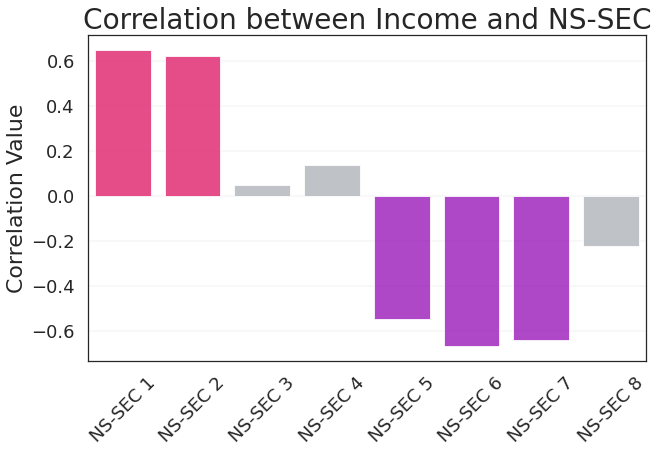

In [16]:
row = []
sec_cols =  ['ns-sec_{}_perc'.format(idx) for idx in range(1, 9)]
df_ = regs_socio.dropna()
for c in sec_cols:
    row.append(pearsonr(df_[c].values, df_.income.values)[0])
sec_income_corr = pd.DataFrame([row], columns=sec_cols)
f, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=sec_income_corr, ax=ax, palette=['#ff0066ff', '#ff0066ff', '#adb5bd', '#adb5bd', 
                                                  '#aa00d4ff', '#aa00d4ff', '#aa00d4ff', '#adb5bd'],
           alpha=0.8)

ax.set_xticklabels(['NS-SEC {}'.format(idx) for idx in range(1, 9)], rotation=45, size=18)
plt.title('Correlation between Income and NS-SEC', fontsize=28)
plt.ylabel('Correlation Value', fontsize=22)
ax.yaxis.set_tick_params(labelsize=18)
plt.grid(axis='y', linewidth=.25)
plt.show()